In [2]:
import time
from scipy.stats import median_absolute_deviation
import scipy.stats
import numpy as np
import pandas as pd
import sqlite3
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from functools import partial, reduce
import plotnine as gg
from numpy import arange


In [34]:
startpath = '/Users/habbasi/Desktop/CDRP/DeepProfiler/'
outpath = '/Users/habbasi/Desktop/CDRP/DeepProfiler/'

In [35]:
def moa_evaluation():
    filenames = ['correlation_matrix.csv', 'cr_median.csv']

    dataset = ['DeepProfiler', 'CellProfiler']

    fpath = [os.path.join(startpath, f) for f in filenames]

    combined_score = []

    for fp, c in zip(fpath, dataset):


            df = pd.read_csv(fp)

            if [col for col in df.columns if 'Unnamed: 0' in col]:

                df.drop(columns = 'Unnamed: 0', inplace=True)

            else:
                df = df


            metadata = (df.drop_duplicates(subset=['Var1', 'Metadata_moa.x'])
                    .filter(['Var1', 'Metadata_moa.x'], axis=1)
                    .rename(columns={'Var1': 'Metadata_broad_sample',
                                "Metadata_moa.x": "Metadata_moa"})
                   )




            test = df.pivot_table(index='Var1', columns='Var2', values='value')






            def normalize_matrix(df):
                tmp = df.where(np.triu(np.ones(df.shape), k=1).astype(bool)).stack()
                tmp = (df - np.median(tmp))/median_absolute_deviation(tmp)
                tmp = tmp/np.nanquantile(tmp, 0.999)*0.999
                tmp[tmp > 1] = 1
                tmp[tmp < -1] = -1
                np.fill_diagonal(tmp.values,1)
                return tmp
            prf = normalize_matrix(test)




            def prepare_sm(prf):

                    tmp1 = (prf.stack()
                            .reset_index()
                            .rename(columns={'Var1': 'Var1',
                                     'Var2': 'Var2',
                                     0: "Value"})
                            .query('Var1 < Var2  and Var1 != "DMSO" and Var2 != "DMSO"')
                            .merge(metadata, left_on='Var1', right_on = 'Metadata_broad_sample', how='left')
                            .merge(metadata, left_on='Var2', right_on = 'Metadata_broad_sample', how='left')
                            .dropna()
                           )
                    tmp1['Metadata_moa_x'] = tmp1['Metadata_moa_x'].str.lower()
                    tmp1['Metadata_moa_y'] = tmp1['Metadata_moa_y'].str.lower()
                    tmp1['same_moa'] = tmp1.apply(lambda x: "True" if x['Metadata_moa_x'] == x['Metadata_moa_y'] else "False", axis=1)


                    return tmp1

            melt = prepare_sm(prf)


            def enrichment_top_conn(melt):

                    top_perc = [num for num in arange(0.98, 0.997, 0.002)]
                    enrichment_score = []
                    for i, p in enumerate(top_perc):

                        thr = np.quantile(melt.Value, p)
                        v11 = (melt.query('Value > @thr  and same_moa == "True"').shape[0])
                        v12 = (melt.query('Value > @thr  and same_moa != "True"').shape[0])
                        v21 = (melt.query('Value < @thr  and same_moa == "True"').shape[0])
                        v22 = (melt.query('Value < @thr  and same_moa != "True"').shape[0])

                        Vector = np.asarray([[v11, v12], [v21, v22]])
                        fishertest = scipy.stats.fisher_exact(Vector, alternative="greater")

                        result = {"top_perc": p,"odds_ratio": fishertest[0], "Pvalue": fishertest[1]}
                        enrichment_score.append(result)
                    tmp = pd.DataFrame(enrichment_score)
                    tmp['top_perc'] = tmp['top_perc'].apply(lambda x: (1 - x)*100)


                    return tmp

            score = enrichment_top_conn(melt)
            score['Dataset'] = str(c)

            combined_score.append(score)

    finalscore =  pd.concat(combined_score) 


    
    
    return finalscore


finalscore = moa_evaluation()
    

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Desktop/CDRP/DeepProfiler//moa_evaluation_cp_dp_features_CDRP.png


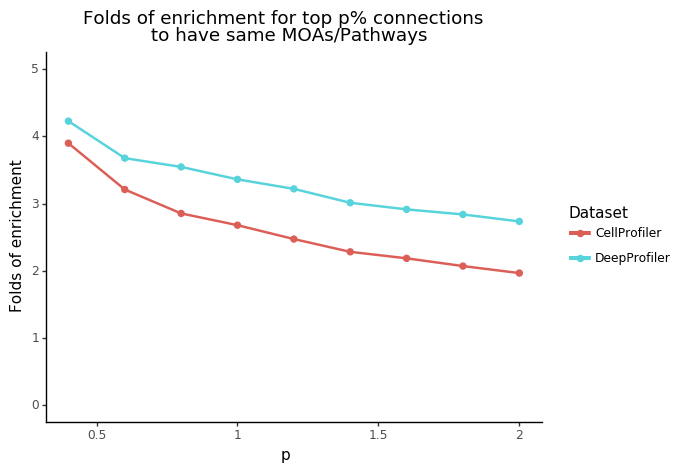

<ggplot: (7024053481)>

In [36]:
p = (gg.ggplot(data=finalscore,mapping=gg.aes(x='top_perc',y='odds_ratio', color='Dataset'))
    + gg.geom_point(size=2)
    + gg.geom_line(size=1)
    + gg.xlab("p")
    + gg.ylab("Folds of enrichment")
    + gg.ylim(0, 5)
    + gg.labs(title="Folds of enrichment for top p% connections \n to have same MOAs/Pathways")
    + gg.theme_classic()
)


gg.ggsave(p,outpath + "/" + 'moa_evaluation_cp_dp_features_CDRP.png')

p